In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gym
import numpy as np


import os, sys
sys.path.insert(0,'..')

from collections import deque 

from dfibert.tracker.nn.rl import Agent, Action_Scheduler
import dfibert.envs.RLtractEnvironment as RLTe
from dfibert.envs._state import TractographyState

In [2]:
# Test on Lunar Lander to check functionality of agent
#env = gym.make('LunarLander-v2')
#n_actions= env.action_space.n

In [2]:
max_steps = 3000000
replay_memory_size = 30000
agent_history_length = 1
evaluate_every = 20000
eval_runs = 20
network_update_every = 1500
start_learning = 700

max_episode_length = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

learning_rate = 0.0001

In [3]:
env = RLTe.RLtractEnvironment(device = 'cpu')
n_actions = env.action_space.n

Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307


In [4]:
def init_transition():
    state = env.reset()
    transition = deque(maxlen=12)
    while len(transition) < 12:
        for i in range(len(state.getCoordinate())):
            transition.append(state.getCoordinate()[i].item())
    return transition

def add_to_transition(state, transition):
    for i in range(len(state.getCoordinate())):
            transition.append(state.getCoordinate()[i].item())
    return transition

In [11]:
state = env.reset()
print(state.getCoordinate())

tensor([43.4998, 94.5377, 24.2661])


In [19]:
transition = init_transition()
print(transition)
next_state, _, _ = env.step(42)
next_transition = add_to_transition(next_state, transition)
print(np.array(next_transition))

deque([73.6513442993164, 107.88105773925781, 93.29415130615234, 73.6513442993164, 107.88105773925781, 93.29415130615234, 73.6513442993164, 107.88105773925781, 93.29415130615234, 73.6513442993164, 107.88105773925781, 93.29415130615234], maxlen=12)
[ 73.6513443  107.88105774  93.29415131  73.6513443  107.88105774
  93.29415131  73.6513443  107.88105774  93.29415131  74.58926433
 108.1431821   93.52130066]


In [25]:
agent = Agent(n_actions=n_actions, inp_size=np.array(transition).shape, device=device, hidden=10, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=32, learning_rate=learning_rate)
#print(agent.main_dqn(torch.FloatTensor([np.array(transition)]).to(device)))
#print(agent.target_dqn(torch.FloatTensor([np.array(transition)]).to(device)))

tensor([[-13.6672,  -7.8499,  -5.0823,  14.6562,  -2.7858,  -0.6165,  10.3545,
          -2.1052,  -6.4893,  -6.9334,  -1.0502,  -5.7020, -10.8006,  -2.3180,
         -11.9924,  -0.8486,   3.1842,  -3.2134,   2.1775,  -0.9403,   3.2331,
           1.7278,  -3.3707, -10.6123,   8.4084, -17.0882,  -3.0332,  -3.0189,
          13.1050,  -5.0179,   7.5423,   4.0707,  -8.9227,  -2.1233,  10.4102,
         -17.7410,  12.1755,  -0.2614,   4.6796,   9.3646,   5.0021,  10.0463,
          -2.7939,  -9.3681,  -5.5738,  -3.8558, -13.2895,   8.2217,   1.9178,
           9.1176,  -4.2744,   8.5829,   9.8390,   4.5286,  -8.5778,   4.4940,
          -2.8302,  18.6438,  -1.0051,   1.0747,  -9.0311,   2.8591,   9.1929,
          -3.2381,  -1.0803,  -8.8236,  -7.3553, -10.1507, -11.5579,   7.1048,
          -4.4199,   5.1859,  13.8964,   1.0838,  -7.0013,  -1.5684,   3.1538,
          -3.0316,   8.9216,   7.6663,   3.3042,  -7.4507,  14.3557,  -6.6734,
         -13.6536,  -1.9597,  -6.0354,  -0.6945,  -5

In [8]:
# Debugging the optimization of the agent

state = env.reset()
state = torch.tensor([state]).to(device).float()
print(state.shape)
print(agent.main_dqn(state))
print(agent.target_dqn(state))

action = 1

next_state, reward, done, _ = env.step(action)
print(next_state, reward, done)

action = torch.tensor([action]).to(device)
next_state = torch.tensor([next_state]).float().to(device)
reward = torch.tensor([reward]).float().to(device)
done = torch.BoolTensor([done]).to(device)
state_action_values = agent.main_dqn(state)
print(state_action_values)
state_action_values = state_action_values[0][action]
print(state_action_values)

next_state_actions = agent.main_dqn(next_state).max(1)[1]
print(next_state_actions)
next_state_values = agent.target_dqn(next_state)[0][next_state_actions]
print(next_state_values)
next_state_values[done] = 0.0
print(next_state_values)
expected_state_action_values = next_state_values.detach() * 0.99 + reward
print(expected_state_action_values)

agent.optimizer.zero_grad()
loss = torch.nn.SmoothL1Loss()(state_action_values, expected_state_action_values)
print(loss)
loss.backward()
agent.optimizer.step()

print(agent.main_dqn(state))
print(agent.target_dqn(state))

torch.Size([1, 8])
tensor([[0.2314, 0.2480, 0.3690, 0.1016]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[0.2314, 0.2480, 0.3690, 0.1016]], device='cuda:0',
       grad_fn=<AddBackward0>)
[ 0.01214266  1.4017366   0.60866606 -0.2167907  -0.01216728 -0.1019486
  0.          0.        ] 0.0867171307642434 False
tensor([[0.2314, 0.2480, 0.3690, 0.1016]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([0.2480], device='cuda:0', grad_fn=<IndexBackward>)
tensor([2], device='cuda:0')
tensor([0.3673], device='cuda:0', grad_fn=<IndexBackward>)
tensor([0.3673], device='cuda:0', grad_fn=<IndexPutBackward>)
tensor([0.4503], device='cuda:0')
tensor(0.0205, device='cuda:0', grad_fn=<SmoothL1LossBackward>)
tensor([[0.2505, 0.2896, 0.3830, 0.1175]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor([[0.2314, 0.2480, 0.3690, 0.1016]], device='cuda:0',
       grad_fn=<AddBackward0>)


In [ ]:
class ToyEnv(gym.Env):
     def __init__(self):
            self.possible_states = []
            self.state, self.

In [ ]:
#state = env.reset()
#agent = Agent(n_actions=n_actions, inp_size=state.shape, device=device, hidden=10, agent_history_length=agent_history_length, memory_size=replay_memory_size, batch_size=32, learning_rate=learning_rate)

transition = init_transition()
agent = Agent(n_actions=n_actions, inp_size=np.array(transition).shape, device=device, hidden=10, agent_history_length=agent_history_length, memory_size=replay_memory_size)#, batch_size=512, learning_rate=learning_rate)
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=30000, eps_final=0.02, replay_memory_start_size=start_learning, model=agent.main_dqn)

step_counter = 0

eps_rewards = []



print("Start training...")
while step_counter < max_steps:
    epoch_step = 0
    #agent.main_dqn.train()
######## fill memory begins here
    while (epoch_step < evaluate_every) or (step_counter < start_learning):
        state = env.reset()
        #transition = init_transition()
        referenceLine = env.referenceStreamline_ijk
        episode_reward_sum = 0
        terminal = False
        #fill replay memory while interacting with env
        #for episode_counter in range(max_episode_length):
        episode_step_counter = 0
        positive_run = 0

        while not terminal:
            # get action with epsilon-greedy strategy       
            action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device))
            
            next_state, reward, terminal = env.step(action)
            next_transition = add_to_transition(next_state, transition)
            
            step_counter += 1
            epoch_step += 1
            episode_step_counter += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                state=np.array(transition),
                                reward=reward,
                                new_state=np.array(next_transition),
                                terminal=terminal)


            #state = next_state
            transition = next_transition



            ####### optimization is happening here
            if step_counter > start_learning:
                #if reward > 0.:
                #    print("reward was positive: ", reward)
                loss = agent.optimize()


            ####### target network update
            if step_counter > start_learning and step_counter % network_update_every == 0:
                #print("Update net")
                #print(agent.main_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                #print(agent.target_dqn(torch.tensor(state).to(device).unsqueeze(0)))
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())

            # if episode ended before maximum step
            if terminal:
                terminal = False
                #state = env.reset()
                transition = init_transition()
                #eps_steps[len(eps_rewards)%10] = episode_step_counter
                #print("Positive rewards of this episode: ", positive_run)
                break

        eps_rewards.append(episode_reward_sum)

        if len(eps_rewards) % 100 == 0:
            #with open(path+'/logs/rewards.dat', 'a') as reward_file:
                #print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("{}, done {} episodes, {}, current eps {}".format(step_counter, len(eps_rewards), np.mean(eps_rewards[-100:]), action_scheduler.eps_current), env.points_visited)
    #torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))

########## evaluation starting here
    eval_rewards = []
    #agent.main_dqn.eval()
    for _ in range(eval_runs):
        eval_steps = 0
        #state = env.reset()
        transition = init_transition()
        eval_episode_reward = 0
        episode_final = 0
        while eval_steps < max_episode_length:
            action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)

            next_state, reward, terminal = env.step(action)
            #next_state = next_state
            next_transition = add_to_transition(next_state, transition)

            eval_steps += 1
            eval_episode_reward += reward
            #state = next_state
            transition = next_transition
            if terminal:
                terminal = False
                if reward == 100:
                    episode_final += 1
                break

        eval_rewards.append(eval_episode_reward)

    print("Evaluation score:", np.mean(eval_rewards))
    print("{} of {} episodes ended close to / at the final state.".format(episode_final, eval_runs))
    if np.mean(eval_rewards) > 10.:
        torch.save(agent.main_dqn.state_dict(), 'trained_agents/multiple/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eval_rewards)))

Start training...
255, done 100 episodes, -91.52257676215422, current eps 1 0
487, done 200 episodes, -93.74538980099233, current eps 1 0
722, done 300 episodes, -92.84386526448344, current eps 0.9993139999999999 0
963, done 400 episodes, -94.27903659944688, current eps 0.9914413333333333 0
1205, done 500 episodes, -92.19572983533861, current eps 0.983536 0
1446, done 600 episodes, -92.13998960303218, current eps 0.9756633333333332 0
1694, done 700 episodes, -91.80794335959835, current eps 0.9675619999999999 0
1954, done 800 episodes, -91.53070089451913, current eps 0.9590686666666666 0
2200, done 900 episodes, -92.94762733928825, current eps 0.9510326666666666 0
2443, done 1000 episodes, -93.08632689534697, current eps 0.9430946666666666 0
2679, done 1100 episodes, -93.7654386284055, current eps 0.9353853333333333 0
2924, done 1200 episodes, -92.28232436813649, current eps 0.9273819999999999 0
3179, done 1300 episodes, -92.75655589469227, current eps 0.919052 0
3444, done 1400 episode

36952, done 10500 episodes, -59.86310136694818, current eps 0.019978947900178495 0
37522, done 10600 episodes, -70.64578301335708, current eps 0.01997702825581787 0
38152, done 10700 episodes, -67.54090552518903, current eps 0.019974906543629812 0
38706, done 10800 episodes, -69.29872323930005, current eps 0.019973040784023174 0
39323, done 10900 episodes, -62.76175148346458, current eps 0.019970962853197726 0
Evaluation score: -44.577124970683585
0 of 20 episodes ended close to / at the final state.
40016, done 11000 episodes, -65.40294873750577, current eps 0.01996862896979086 0
40639, done 11100 episodes, -54.41928360389338, current eps 0.01996653083218267 0
41321, done 11200 episodes, -55.30817961649798, current eps 0.01996423399454417 0
42028, done 11300 episodes, -58.34112740332852, current eps 0.019961852961977573 0
42664, done 11400 episodes, -61.847108364945605, current eps 0.01995971104300677 0
43405, done 11500 episodes, -56.872060224369115, current eps 0.01995721550533796 0

Evaluation score: -31.88673207929539
0 of 20 episodes ended close to / at the final state.
100459, done 20100 episodes, -67.17986074445741, current eps 0.019765069208230897 0
101072, done 20200 episodes, -66.44629800229009, current eps 0.019763004748593948 0
101686, done 20300 episodes, -64.93762563090752, current eps 0.01976093692115987 0
102241, done 20400 episodes, -69.02836960634086, current eps 0.019759067793756104 0
102878, done 20500 episodes, -68.49473466740872, current eps 0.01975692250698818 0
103465, done 20600 episodes, -66.2737664499189, current eps 0.01975494561007645 0
104099, done 20700 episodes, -68.92194031755565, current eps 0.019752810426699897 0
104759, done 20800 episodes, -68.58073812646994, current eps 0.019750587680598123 0
105404, done 20900 episodes, -66.45081604633225, current eps 0.019748415451453206 0
106150, done 21000 episodes, -60.55705376645089, current eps 0.019745903074798777 0
106885, done 21100 episodes, -55.72332244057929, current eps 0.0197434277

164590, done 29500 episodes, -37.558011556558334, current eps 0.019549089010877985 0
165461, done 29600 episodes, -33.16594495894446, current eps 0.019546155659583068 0
166272, done 29700 episodes, -39.57158123773962, current eps 0.019543424376115583 0
167007, done 29800 episodes, -55.01057585503375, current eps 0.019540949045229516 0
167761, done 29900 episodes, -47.8076902595503, current eps 0.019538409726198094 0
168764, done 30000 episodes, -14.43886377719857, current eps 0.019535031825682822 0
169643, done 30100 episodes, -43.32483678726392, current eps 0.019532071532010913 0
170569, done 30200 episodes, -29.9809871583543, current eps 0.019528952951874182 0
171381, done 30300 episodes, -45.30626659700855, current eps 0.019526218300609573 0
172248, done 30400 episodes, -38.686818758982696, current eps 0.01952329842050315 0
173052, done 30500 episodes, -56.30101047403763, current eps 0.019520590711615535 0
174027, done 30600 episodes, -40.96627715224999, current eps 0.01951730710941

239843, done 39000 episodes, -43.12455876657601, current eps 0.019295652173913044 0
Evaluation score: -25.95837259242673
0 of 20 episodes ended close to / at the final state.
240618, done 39100 episodes, -48.433289230432145, current eps 0.01929304213114202 0
241362, done 39200 episodes, -50.21661618254795, current eps 0.01929053649008184 0
242069, done 39300 episodes, -54.89383004727318, current eps 0.019288155457515242 0
242801, done 39400 episodes, -46.25634921598822, current eps 0.019285690230020545 0
243529, done 39500 episodes, -61.29189695205896, current eps 0.019283238473714347 0
244192, done 39600 episodes, -61.644041337099125, current eps 0.0192810056242212 0
244749, done 39700 episodes, -74.89017372353686, current eps 0.019279129761223184 0
245561, done 39800 episodes, -51.26810958706308, current eps 0.01927639510995858 0
246348, done 39900 episodes, -48.84769586062059, current eps 0.01927374465362207 0
247046, done 40000 episodes, -56.354983842138, current eps 0.019271393931

305716, done 48400 episodes, -57.990808941957795, current eps 0.019073805273970297 0
306216, done 48500 episodes, -73.69926574769043, current eps 0.019072121375408348 0
306753, done 48600 episodes, -72.22547091807046, current eps 0.019070312868352812 0
307486, done 48700 episodes, -60.304883052327526, current eps 0.01906784427306099 0
308043, done 48800 episodes, -73.21511058203131, current eps 0.01906596841006298 0
308579, done 48900 episodes, -73.35327486481225, current eps 0.01906416327080457 0
309176, done 49000 episodes, -73.69596426744077, current eps 0.0190621526959216 0
309675, done 49100 episodes, -71.9124383830223, current eps 0.019060472165156772 0
310215, done 49200 episodes, -72.12050416645721, current eps 0.019058653554709867 0
310942, done 49300 episodes, -58.370833843404036, current eps 0.01905620516620079 0
311691, done 49400 episodes, -57.845854518413, current eps 0.01905368268615499 0
312482, done 49500 episodes, -54.101022219579406, current eps 0.01905101875862998 0

368021, done 57900 episodes, -60.08037253226208, current eps 0.01886397467416563 0
368693, done 58000 episodes, -54.71810936633633, current eps 0.018861711514498367 0
369471, done 58100 episodes, -55.32595191789024, current eps 0.018859091368335974 0
370125, done 58200 episodes, -66.14323410108591, current eps 0.01885688882901694 0
370842, done 58300 episodes, -66.80121374144306, current eps 0.018854474118479105 0
371551, done 58400 episodes, -55.14133429013578, current eps 0.018852086350318258 0
372311, done 58500 episodes, -51.02728487133734, current eps 0.018849526824504092 0
372899, done 58600 episodes, -67.09274174195923, current eps 0.018847546559795238 0
373609, done 58700 episodes, -53.142934607819896, current eps 0.01884515542383727 0
374272, done 58800 episodes, -64.13151657085724, current eps 0.018842922574344122 0
374877, done 58900 episodes, -67.66140948014717, current eps 0.018840885057084162 0
375695, done 59000 episodes, -40.90563950908305, current eps 0.018838130199036

In [24]:
eval_rewards = []
all_distances = []
all_states = []
#agent.main_dqn.eval()
for _ in range(1):
    eval_steps = 0
    #state = env.reset()
    #print(state.getCoordinate())
    #all_states.append(state.getCoordinate())
    transition = init_transition()
    all_states.append(torch.tensor(list(transition)[:3]))
    eval_episode_reward = 0
    episode_final = 0
    print(env.referenceStreamline_ijk[:6])
    
    while eval_steps < max_episode_length:
        action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)

        next_state, reward, terminal = env.step(action)
        #next_state = next_state
        next_transition = add_to_transition(next_state, transition)
        #reward = 1 + (1+(reward/10))
        #if reward > 1:
        #    reward = 1
        #elif reward > 0.:
        #    reward = 0
        #else:
        #    reward = -1
        eval_episode_reward += reward
        print(eval_steps, action, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([eval_steps,len(env.referenceStreamline_ijk)-1])].numpy(), reward)
        eval_steps += 1
        all_distances.append(reward)
        all_states.append(next_state.getCoordinate())
        
        #state = next_state
        transition = next_transition
        if terminal:
            terminal = False
            #if reward > 0.9:
            #    episode_final += 1
            break

    eval_rewards.append(eval_episode_reward)

print("Evaluation score:", np.min(eval_rewards))

tensor([[43.4998, 94.5377, 24.2661],
        [42.8719, 94.4639, 24.7563],
        [42.2316, 94.5010, 25.2345],
        [41.5913, 94.5380, 25.7127],
        [40.8953, 94.6029, 26.1017],
        [40.2550, 94.6399, 26.5799]])
0 97 [42.54434095 94.81857103 24.1755491 ] [43.4998  94.53768 24.26608] 23.15581395348837
1 2 [42.52571373 94.58630794 25.14802371] [42.871902 94.46394  24.75629 ] 23.15581395348837
2 12 [41.93567501 94.22950766 25.87228048] [42.231613 94.50095  25.234474] 23.155813953488362
3 25 [41.07959335 93.97352899 26.32127839] [41.591324 94.537964 25.712658] 23.155813953488376
4 25 [40.2235117  93.71755031 26.7702763 ] [40.895332 94.602905 26.101734] 23.155813953488376
5 17 [39.52677332 93.715097   27.48759744] [40.255043 94.639915 26.579918] 23.155813953488376
6 25 [38.67069167 93.45911832 27.93659534] [39.614754 94.676926 27.058102] -0.09999999999999432
7 14 [38.21292173 94.05692495 28.59467886] [39.11261  94.762375 27.674988] -0.09999999999999432
8 11 [38.4159608  94.748041

In [ ]:
state = env.reset()


In [27]:
def sphere_dist(nextState):
    current_index = np.min([env.stepCounter,len(env.referenceStreamline_ijk)-1])
    x_dist = (nextState.getCoordinate()[0] - env.referenceStreamline_ijk[current_index][0]) **2
    y_dist = (nextState.getCoordinate()[1] - env.referenceStreamline_ijk[current_index][1]) **2
    z_dist = (nextState.getCoordinate()[2] - env.referenceStreamline_ijk[current_index][2]) **2
    return x_dist + y_dist + z_dist

In [32]:
print(agent.gamma)

0.99


In [40]:
for i in range(n_actions):
    state = env.reset()
    next_state, reward, done = env.step(i)
    s_dist = sphere_dist(next_state)
    old_dist = torch.sum((env.referenceStreamline_ijk[env.stepCounter] - next_state.getCoordinate())**2)
    if s_dist <= 0.52**2:
        print(i, reward, s_dist, old_dist)

47 11.394252873563218 tensor(0.1970, dtype=torch.float64) tensor(0.1970, dtype=torch.float64)
67 11.394252873563218 tensor(0.2640, dtype=torch.float64) tensor(0.2640, dtype=torch.float64)
72 11.394252873563218 tensor(0.2650, dtype=torch.float64) tensor(0.2650, dtype=torch.float64)
75 11.394252873563218 tensor(0.1352, dtype=torch.float64) tensor(0.1352, dtype=torch.float64)
80 11.394252873563218 tensor(0.0623, dtype=torch.float64) tensor(0.0623, dtype=torch.float64)
88 11.394252873563218 tensor(0.0726, dtype=torch.float64) tensor(0.0726, dtype=torch.float64)
93 11.394252873563218 tensor(0.1499, dtype=torch.float64) tensor(0.1499, dtype=torch.float64)
96 11.394252873563218 tensor(0.1986, dtype=torch.float64) tensor(0.1986, dtype=torch.float64)


In [15]:
next_state, reward, done = env.step(75)
print(next_state.getCoordinate(), reward)

[ 77.07567091 108.90497243  91.49815967] -100


In [43]:
print(list(transition)[:3])

[30.283401924575482, 102.46417647849394, 66.32755479299973]


In [19]:
state = env.reset()
#referenceLine = env.referenceStreamline_ijk
print(state.getCoordinate())
#print(referenceLine[:10])

tensor([ 24.1166, 103.8659,  64.9889])


In [28]:
next_state, reward, done = env.step(74)
print(next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter, len(referenceLine)])].numpy(), reward)

[ 23.13776944 102.38550419  64.06677327] [ 30.125023 102.08756   66.46997 ] -100


In [11]:
optimal_steps =  [80, 88, 54, 96, 100, 67, 83, 75, 83, 75, 100, 83, 70, 67, 59, 100, 67, 59, 59, 59, 51, 100, 59, 56, 51, 61, 100, 66, 71, 66, 71, 71, 100, 71, 71, 71, 71, 100, 92, 84, 84, 38, 100, 97, 97, 97, 38, 100, 97, 30, 43, 43, 48, 100, 94, 81, 94, 35, 97, 100, 35, 22, 35, 35, 6, 100, 19, 3, 16, 3, 21, 100, 21, 16, 34, 21, 98, 34, 100, 39, 93, 39, 72, 72, 100, 69, 100]
transition = init_transition()
referenceLine = env.referenceStreamline_ijk
print(len(referenceLine))

71


In [34]:
#action = action_scheduler.get_action(step_counter, torch.FloatTensor([np.array(transition)]).to(device), evaluation=True)
next_state, reward, terminal = env.step(88)
next_transition = add_to_transition(next_state, transition)
print(action, reward)
transition = next_transition

80 -0.09999999999999964


In [4]:
# Debugging the reward function
referenceLine = env.referenceStreamline_ijk
stepCounter = 0
maxSteps=200
state = env.reset()
print("State: ", state.getCoordinate().numpy())
next_state, _, terminal = env.step(80)
print("Next State: ", next_state.getCoordinate().numpy())

def lineseg_dist(p, a, b):

    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))

    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])

    # perpendicular distance component
    c = np.cross(p - a, d)

    return np.hypot(h, np.linalg.norm(c))

distance = lineseg_dist(referenceLine[86].numpy(), referenceLine[85].numpy(), referenceLine[86].numpy())
print(distance)

#print("Diff: ", next_state.getCoordinate().numpy()-state.getCoordinate().numpy())
#qry_pt = next_state.getCoordinate().view(-1,3)
#print("Reference next state: ", referenceLine[stepCounter+1])
#print("Diff to reference state: ", referenceLine[stepCounter+1]-next_state.getCoordinate().numpy())
#distance = torch.min(torch.sum((referenceLine[np.min([stepCounter+1, maxSteps-1])] - qry_pt)**2, dim=1))
#print(distance)
#reward = torch.tanh(-distance+5.3)

#if distance == -1:
#    reward = 0.5
#elif distance < 0.8:
#    reward = 1+ (1-distance)
#else:
#    reward = np.max([1 - distance, -1])
#print(reward)

State:  [ 73.651344 107.88106   93.29415 ]
Next State:  [ 74.56195007 107.80595503  92.88775652]
7.450580596923828e-09


In [9]:
state = np.array([ 75.6, 107.95,  92.22])
line = np.array([ 75.78847, 107.96255,  92.28433])

print(np.linalg.norm(line - state, 2))

sphere_dist = ((state[0] - line[0])**2 + (state[1]-line[1])**2 + (state[2]-line[2])**2)
print(sphere_dist)
normal_diff = np.sum(state-line)**2
print(normal_diff)
if sphere_dist < 0.2**2:
    print(True)
else:
    print(False)

0.19954145509142476
0.03981679230000309
0.07041062249999892
True


In [7]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82, 100]
eps_reward = 0
state = env.reset()
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    state = next_state
    eps_reward += reward.item()
    print("Action: ", i, "Reward: ", reward.item())
print(eps_reward)

Action:  100 Reward:  -0.6400096416473389
Action:  80 Reward:  -0.3780286503520091
Action:  75 Reward:  -0.17094774926353554
Action:  80 Reward:  -0.06020208127816557
Action:  75 Reward:  -0.023724592605490286
Action:  100 Reward:  -0.023724592605490286
Action:  62 Reward:  -0.031680450691759385
Action:  75 Reward:  -0.10966306950569177
Action:  83 Reward:  -0.2621558822401104
Action:  75 Reward:  -0.4853828474102172
Action:  83 Reward:  -0.7713330234194417
Action:  100 Reward:  -0.7713330234194417
Action:  83 Reward:  -1.158927472394806
Action:  62 Reward:  -1.6468544226974164
Action:  67 Reward:  -2.2078664481054533
Action:  51 Reward:  -2.459970885856384
Action:  67 Reward:  -3.0430611441644246
Action:  100 Reward:  -3.0430611441644246
Action:  59 Reward:  -3.7319386628026487
Action:  59 Reward:  -4.531517914723884
Action:  59 Reward:  -5.427621034792285
Action:  100 Reward:  -5.427621034792285
Action:  59 Reward:  -6.420164664306009
Action:  56 Reward:  -7.21012573500936
Action:  5

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Init environment..")
env = RLTe.RLtractEnvironment(device = 'cpu')
print("..done!")
n_actions = env.action_space.n
#print(n_actions)

Init environment..
Loading precomputed streamlines (data/HCP307200_DTI_smallSet.vtk) for ID 100307
..done!


In [8]:
referenceLine = env.referenceStreamline_ijk
print(referenceLine.shape)

torch.Size([87, 3])


In [5]:
print(referenceLine[0])
state = TractographyState(referenceLine[0], env.interpolateDWIatState)
print(state.getCoordinate())

tensor([47.8702, 74.8030, 26.6401])
tensor([47.8702, 74.8030, 26.6401])


In [6]:
possible_actions = []
past_state = env.reset()
all_next_states = []
for i in range(len(referenceLine)):
    best_actions = []
    next_states = []
    for z in range(n_actions):
        env.state = TractographyState(referenceLine[i], env.interpolateDWIatState)
        next_state, reward, _ = env.step(z)
        env.stepCounter = i
        #if reward == -1:
        #    reward = 0
        #elif reward < 0.2:
        if reward > 1.0:
            print("Step: ", i, "Action: ", z, "Distance: ", reward)
        #    reward = 1
        #elif reward < 1.:
        #    reward = 0
        #else:
        #    reward = -1
        #if reward == 1:
        #    best_actions.append(z)
            #print(i, z, referenceLine[i].numpy(), next_state.getCoordinate().numpy(), reward)
    print(i, best_actions)
    #print(i, reward)
    #if reward > 0.9:
    #    best_actions.append(i)
    possible_actions.append(best_actions)

Step:  0 Action:  41 Distance:  tensor(1.3545, dtype=torch.float64)
Step:  0 Action:  66 Distance:  tensor(1.2187, dtype=torch.float64)
Step:  0 Action:  74 Distance:  tensor(1.5895, dtype=torch.float64)
Step:  0 Action:  79 Distance:  tensor(1.4856, dtype=torch.float64)
Step:  0 Action:  82 Distance:  tensor(1.2496, dtype=torch.float64)
Step:  0 Action:  87 Distance:  tensor(1.5944, dtype=torch.float64)
Step:  0 Action:  95 Distance:  tensor(1.5184, dtype=torch.float64)
0 []
Step:  1 Action:  61 Distance:  tensor(1.3162, dtype=torch.float64)
Step:  1 Action:  66 Distance:  tensor(1.2710, dtype=torch.float64)
Step:  1 Action:  74 Distance:  tensor(1.6272, dtype=torch.float64)
Step:  1 Action:  79 Distance:  tensor(1.3920, dtype=torch.float64)
Step:  1 Action:  82 Distance:  tensor(1.4070, dtype=torch.float64)
Step:  1 Action:  87 Distance:  tensor(1.4471, dtype=torch.float64)
Step:  1 Action:  95 Distance:  tensor(1.5094, dtype=torch.float64)
1 []
Step:  2 Action:  41 Distance:  tensor

Step:  17 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
17 []
Step:  18 Action:  64 Distance:  tensor(1.2763, dtype=torch.float64)
Step:  18 Action:  69 Distance:  tensor(1.5565, dtype=torch.float64)
Step:  18 Action:  77 Distance:  tensor(1.5700, dtype=torch.float64)
Step:  18 Action:  82 Distance:  tensor(1.4267, dtype=torch.float64)
Step:  18 Action:  90 Distance:  tensor(1.5504, dtype=torch.float64)
Step:  18 Action:  98 Distance:  tensor(1.2671, dtype=torch.float64)
18 []
Step:  19 Action:  64 Distance:  tensor(1.2807, dtype=torch.float64)
Step:  19 Action:  69 Distance:  tensor(1.5051, dtype=torch.float64)
Step:  19 Action:  77 Distance:  tensor(1.6072, dtype=torch.float64)
Step:  19 Action:  82 Distance:  tensor(1.3555, dtype=torch.float64)
Step:  19 Action:  85 Distance:  tensor(1.2477, dtype=torch.float64)
Step:  19 Action:  90 Distance:  tensor(1.5722, dtype=torch.float64)
Step:  19 Action:  98 Distance:  tensor(1.3832, dtype=torch.float64)
19 []
Step:  20 Action

Step:  34 Action:  34 Distance:  tensor(1.2363, dtype=torch.float64)
34 []
Step:  35 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  35 Action:  5 Distance:  tensor(1.4896, dtype=torch.float64)
Step:  35 Action:  8 Distance:  tensor(1.3297, dtype=torch.float64)
Step:  35 Action:  13 Distance:  tensor(1.6255, dtype=torch.float64)
Step:  35 Action:  18 Distance:  tensor(1.5023, dtype=torch.float64)
Step:  35 Action:  21 Distance:  tensor(1.3069, dtype=torch.float64)
Step:  35 Action:  26 Distance:  tensor(1.4191, dtype=torch.float64)
Step:  35 Action:  34 Distance:  tensor(1.2754, dtype=torch.float64)
35 []
Step:  36 Action:  0 Distance:  tensor(1.6504, dtype=torch.float64)
Step:  36 Action:  5 Distance:  tensor(1.4574, dtype=torch.float64)
Step:  36 Action:  8 Distance:  tensor(1.3736, dtype=torch.float64)
Step:  36 Action:  13 Distance:  tensor(1.6424, dtype=torch.float64)
Step:  36 Action:  18 Distance:  tensor(1.4433, dtype=torch.float64)
Step:  36 Action:  21 Distan

Step:  49 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  49 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
49 []
Step:  50 Action:  0 Distance:  tensor(1.5322, dtype=torch.float64)
Step:  50 Action:  8 Distance:  tensor(1.3821, dtype=torch.float64)
Step:  50 Action:  13 Distance:  tensor(1.5176, dtype=torch.float64)
Step:  50 Action:  21 Distance:  tensor(1.6158, dtype=torch.float64)
Step:  50 Action:  26 Distance:  tensor(1.2182, dtype=torch.float64)
Step:  50 Action:  29 Distance:  tensor(1.3106, dtype=torch.float64)
Step:  50 Action:  34 Distance:  tensor(1.5309, dtype=torch.float64)
Step:  50 Action:  42 Distance:  tensor(1.3322, dtype=torch.float64)
50 []
Step:  51 Action:  0 Distance:  tensor(1.5321, dtype=torch.float64)
Step:  51 Action:  5 Distance:  tensor(1.2367, dtype=torch.float64)
Step:  51 Action:  8 Distance:  tensor(1.4490, dtype=torch.float64)
Step:  51 Action:  13 Distance:  tensor(1.5675, dtype=torch.float64)
Step:  51 Action:  21 Dista

IndexError: index 58 is out of bounds for dimension 0 with size 58

In [12]:
step_distance = []
optimal_steps = []#[100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48]

In [13]:
last_state = env.reset()
print(len(env.referenceStreamline_ijk))

43


In [16]:
steps = 0
while len(optimal_steps) < 44:
    step_distance = []
    for i in range(n_actions):
        env.reset()
        if len(optimal_steps)>0:
            for z in range(len(optimal_steps)):
                _,_,_ = env.step(optimal_steps[z])
        next_state, _, terminal = env.step(i)
        #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[np.min([len(optimal_steps), 85])].numpy(), referenceLine[np.min([len(optimal_steps)+1, len(referenceLine)-1])].numpy())
        #distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][0])**2 \
        #              + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][1])**2 \
        #              + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, 58])][2])**2)
        current_index = np.min([env.stepCounter, len(env.referenceStreamline_ijk)-1])
        qry_pt = next_state.getCoordinate().view(-1,3)
        distance = torch.sum((env.referenceStreamline_ijk[current_index] - qry_pt)**2)
        
        step_distance.append(distance)
    optimal_steps.append(np.argmin(step_distance))
print(optimal_steps)

Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! :D
Hey, hey, hey we finally stopped at the terminal state! 

KeyboardInterrupt: 

In [4]:
# For Streamline with len 44 (index 4)
#print(optimal_steps)
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 17, 37, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [6]:
# with line distance
#optimal_steps = [80, 88, 54, 96, 46, 75, 75, 75, 83, 75, 83, 83, 62, 54, 1, 59, 54, 59, 59, 67, 56, 59, 51, 59, 61, 11, 53, 61, 66, 71, 71, 79, 58, 71, 71, 71, 21, 71, 84, 92, 84, 92, 97, 84, 43, 84, 30, 97, 47, 97, 43, 30, 89, 35, 94, 73, 48, 89, 22, 72, 43, 35, 22, 35, 35, 6, 19, 3, 16, 16, 66, 16, 8, 21, 29, 21, 26, 26, 93, 26, 93, 85, 35, 85, 72, 77, 100]
optimal_steps = [100, 80, 75, 80, 75, 100, 62, 75, 83, 75, 83, 100, 83, 62, 67, 51, 67, 100, 59, 59, 59, 100, 59, 56, 51, 56, 66, 100, 66, 71, 71, 79, 58, 100, 71, 71, 84, 71, 100, 92, 84, 92, 97, 100, 97, 38, 97, 43, 38, 100, 43, 43, 89, 48, 100, 94, 81, 48, 43, 100, 35, 43, 35, 22, 27, 100, 6, 11, 3, 16, 100, 8, 29, 21, 21, 100, 34, 26, 26, 93, 39, 100, 93, 72, 77, 77, 101]

In [ ]:
#optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 1

In [70]:
optimal_steps = [80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]
print(optimal_steps) # <-- min of max distance reward streamline 0

[80, 75, 80, 75, 62, 75, 83, 96, 51, 24, 62, 62, 62, 77, 65, 64, 67, 59, 56, 83, 82, 54, 56, 53, 56, 38, 56, 84, 66, 71, 71, 64, 97, 84, 71, 71, 38, 51, 30, 92, 97, 84, 43, 79, 27, 46, 89, 25, 81, 25, 48, 43, 86, 48, 57, 14, 89, 43, 43, 19, 92, 14, 27, 9, 78, 4, 16, 3, 29, 3, 47, 6, 42, 21, 39, 5, 72, 34, 98, 88, 90, 75, 77, 59, 49, 32, 82]


In [74]:
optimal_steps = [80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]
print(optimal_steps) # <-- min reward

[80, 88, 54, 96, 59, 37, 54, 37, 67, 91, 62, 78, 64, 70, 64, 62, 69, 83, 56, 59, 59, 53, 42, 53, 53, 56, 79, 58, 87, 60, 87, 58, 92, 52, 46, 58, 38, 58, 30, 58, 38, 84, 17, 55, 30, 76, 25, 76, 17, 76, 17, 81, 30, 86, 48, 65, 27, 97, 14, 84, 6, 97, 14, 89, 3, 27, 8, 19, 13, 19, 13, 29, 8, 96, 2, 88, 31, 47, 26, 59, 5, 72, 72, 85, 61, 39]


In [25]:
# change optimal steps
optimal_steps = [17, 30, 100, 17, 30, 17, 17, 6, 0, 6, 0, 0, 0, 78, 24, 16, 24, 24, 100, 37, 45, 45, 70, 100, 99, 86, 86, 78, 94, 62, 100, 65, 70, 86, 65, 100, 86, 94, 99, 45, 99, 100, 100]

In [31]:
state = env.reset()
print(env.state.getCoordinate().numpy(), env.referenceStreamline_ijk[0])
step = 1
all_distances = []
all_states = []
len_line = len(env.referenceStreamline_ijk)-1
all_states.append(state.getCoordinate())
for i in optimal_steps:
    next_state, reward, terminal = env.step(i)
    print(step, reward)
    #current_index = np.min([env.points_visited+1,len(env.referenceStreamline_ijk)-1])
    #print("Reference Line at current index: ", env.referenceStreamline_ijk[current_index])
    #distance = lineseg_dist(next_state.getCoordinate().numpy(), referenceLine[step-1].numpy(), referenceLine[np.min([step, len(referenceLine)-1])].numpy())
    #distance = 2 + (distance/10)
    distance = ((next_state.getCoordinate()[0] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][0])**2 \
                      + (next_state.getCoordinate()[1] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][1])**2 \
                      + (next_state.getCoordinate()[2] - env.referenceStreamline_ijk[np.min([env.stepCounter, len_line])][2])**2)
    #print(step, i, next_state.getCoordinate().numpy(), env.referenceStreamline_ijk[np.min([env.stepCounter,len_line])].numpy(), reward, distance.item(), distance <= 0.55**2)
    all_distances.append(distance)
    all_states.append(next_state.getCoordinate())
    #if distance < 0.71:
    #    reward = 1 - distance
    #    #print(reward)
    #    if reward < 0.3:
    #        reward = 1
    step += 1

print(np.min(all_distances), np.max(all_distances), np.sum(all_distances))

[43.4998  94.53768 24.26608] tensor([43.4998, 94.5377, 24.2661])
tensor([[42.8031, 94.5352, 24.9834]], dtype=torch.float64)
tensor(0.0614, dtype=torch.float64)
1 23.15581395348837
tensor([[41.8925, 94.6103, 25.3898]], dtype=torch.float64)
tensor(0.1511, dtype=torch.float64)
2 23.15581395348837
tensor([[41.8925, 94.6103, 25.3898]], dtype=torch.float64)
tensor(0.2002, dtype=torch.float64)
3 23.155813953488362
tensor([[41.1957, 94.6079, 26.1071]], dtype=torch.float64)
tensor(0.0903, dtype=torch.float64)
4 23.155813953488376
tensor([[40.2851, 94.6830, 26.5135]], dtype=torch.float64)
tensor(0.0072, dtype=torch.float64)
5 23.155813953488376
tensor([[39.5884, 94.6805, 27.2308]], dtype=torch.float64)
tensor(0.0305, dtype=torch.float64)
6 23.155813953488376
tensor([[38.8916, 94.6781, 27.9482]], dtype=torch.float64)
tensor(0.1306, dtype=torch.float64)
7 23.155813953488376
tensor([[38.7411, 95.2013, 28.7869]], dtype=torch.float64)
tensor(0.2268, dtype=torch.float64)
8 23.155813953488376
tensor([[

In [49]:
print(env.referenceStreamline_ijk[4])
print(env.referenceStreamline_ijk.T[1][4])

tensor([ 76.4527, 108.1185,  91.8665])
tensor(108.1185)


<IPython.core.display.Javascript object>


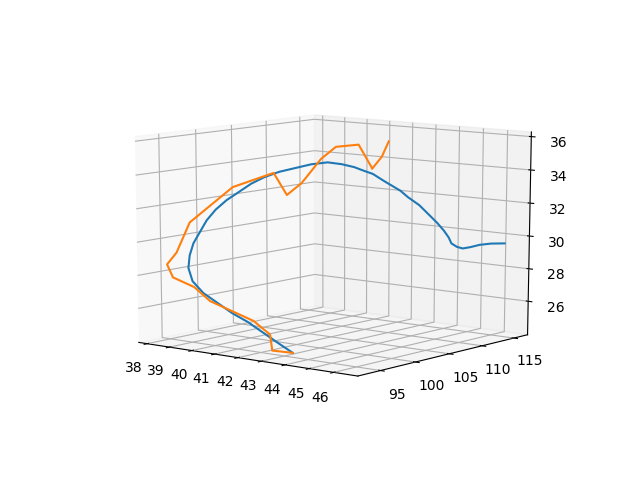

In [11]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

#for i in range(len(states)):
#    print(states[i], env.referenceStreamline_ijk[i])
#    distance = ((states.T[0][i] - env.referenceStreamline_ijk.T[0][i])**2 \
#                      + (states.T[1][i] - env.referenceStreamline_ijk.T[1][i] )**2 \
#                      + (states.T[2][i] - env.referenceStreamline_ijk.T[2][i])**2)
#    print(distance)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(env.referenceStreamline_ijk.T[0], env.referenceStreamline_ijk.T[1], env.referenceStreamline_ijk.T[2])
ax.plot3D(states.T[0][:], states.T[1][:], states.T[2][:])
#print(optimal_steps[:])

In [10]:
states = torch.stack(all_states)
print(states.T[0][:3])

tensor([43.4998, 42.5443, 42.5257], dtype=torch.float64)


In [72]:
print(referenceLine[86])

tensor([ 71.7731, 113.9662,  79.6186])


In [70]:
env.reset()
print(env.state.getCoordinate().numpy(), referenceLine[0])
step = 0
#all_rewards = []
eps_reward = 0
for i in optimal_steps:
    next_state, distance, terminal = env.step(i)
    if distance < 0.71:
        reward = 1 - distance
        #print(reward)
        if reward < 0.3:
            reward = 1
    eps_reward += reward
    #all_rewards.append(reward)
    step += 1
print(eps_reward)

[ 73.651344 107.88106   93.29415 ] tensor([ 73.6513, 107.8811,  93.2942])
tensor(66.2049, dtype=torch.float64)


In [ ]:
for i in range(n_actions):
    
    next_state, distance, terminal = env.step(i)
    

In [8]:
env.reset()
terminal = False
step = 0
actions = []
past_state = env.state
step = 1
while terminal != True:
    for i in range(n_actions)
    action = np.random.randint(n_actions)
    next_state, reward, terminal = env.step(action)
    if reward < 1:
        actions.append(action)
        past_state = next_state
        print("Action: ", action, "Step: ",step, "Coordinates: ", next_state.getCoordinate().numpy(), referenceLine[step].numpy())
        step += 1
    else:
        env.state = past_state
        env.stepCounter = step
    #action = np.random.choice(possible_actions[step])
    #next_state, reward, terminal = env.step(action)
    #step += 1

print(actions)

Action:  100 Step:  1 Coordinates:  [ 73.651344 107.88106   93.29415 ] [ 74.42344 107.87124  93.08491]
Action:  67 Step:  2 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.16057  107.88882   92.774536]
Action:  100 Step:  3 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 75.78847 107.96255  92.28433]
Action:  100 Step:  4 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 76.45265  108.118454  91.86654 ]
Action:  100 Step:  5 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.116844 108.27435   91.448746]
Action:  100 Step:  6 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 77.739716 108.54131   91.02359 ]
Action:  100 Step:  7 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.36259  108.80828   90.598434]
Action:  100 Step:  8 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 78.996666 109.15176   90.25207 ]
Action:  100 Step:  9 Coordinates:  [ 74.34808267 107.88351105  92.57683017] [ 79.630745 109.495224  89.9057  ]
Actio

KeyboardInterrupt: 

In [16]:
print(referenceLine[6])
print(referenceLine[7])

tensor([ 77.7397, 108.5413,  91.0236])
tensor([ 78.3626, 108.8083,  90.5984])


In [11]:
state = TractographyState(torch.Tensor([ 77.8994346, 108.7020324, 90.72022516]), env.interpolateDWIatState)
for i in range(n_actions):
    env.state = state
    env.stepCounter -= 1
    next_state, _, terminal = env.step(i)
    qry_pt = next_state.getCoordinate().view(-1,3)
    distance = torch.min(torch.sum((referenceLine[7] - qry_pt)**2, dim=1))
    if distance < 0.3:
        print(i, next_state.getCoordinate().numpy(), referenceLine[7].numpy(), distance.numpy())

tensor([ 78.1077, 108.7354,  91.6977], dtype=torch.float64)
tensor([ 77.7615, 108.8643,  91.6973], dtype=torch.float64)
tensor([ 77.8808, 108.4698,  91.6927], dtype=torch.float64)
tensor([ 78.0768, 109.0850,  91.6268], dtype=torch.float64)
tensor([ 77.5148, 108.5987,  91.6375], dtype=torch.float64)
tensor([ 78.3125, 108.4477,  91.5947], dtype=torch.float64)
tensor([ 77.7489, 109.2253,  91.5590], dtype=torch.float64)
tensor([ 77.6419, 108.2420,  91.5700], dtype=torch.float64)
tensor([ 78.4297, 108.8083,  91.5614], dtype=torch.float64)
tensor([ 77.4379, 108.9717,  91.5654], dtype=torch.float64)
tensor([ 78.0813, 108.1849,  91.5566], dtype=torch.float64)
tensor([ 78.1025, 109.3932,  91.4139], dtype=torch.float64)
tensor([ 77.3094, 108.3452,  91.4445], dtype=torch.float64)
tensor([ 78.6147, 108.4838,  91.3841], dtype=torch.float64)
tensor([ 77.4417, 109.2998,  91.3783], dtype=torch.float64)
tensor([ 77.8415, 107.9787,  91.4083], dtype=torch.float64)
tensor([ 78.3907, 109.1557,  91.4638], d

In [9]:
env.reset()
next_state, reward, terminal = env.step(100)
print(next_state.getCoordinate().numpy())
print(reward)
print(terminal)

tensor(187.0214)
[ 73.651344 107.88106   93.29415 ]
-1
True


In [49]:
print(possible_actions)

[[47, 75, 80, 88, 93, 96], [67, 75, 80, 88, 93], [62, 67, 75, 80], [62, 67, 75, 80, 83], [62, 67, 75, 80, 83], [62, 67, 75, 83, 96], [62, 67, 75, 83, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 75, 83, 91, 96], [62, 70, 75, 83, 91, 96], [62, 70, 75, 78, 83, 91], [54, 57, 62, 67, 70, 75, 83], [54, 62, 67, 75], [54, 59, 67, 72], [51, 54, 59, 62, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 54, 56, 59, 64, 67, 72], [51, 56, 59, 64], [51, 56, 59, 64], [51, 56, 59, 64], [50, 51, 53, 56, 59], [50, 51, 53, 56, 61, 66], [53, 58, 61, 66, 74, 79], [58, 66, 71, 74, 79], [58, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79], [58, 63, 66, 71, 79, 84], [58, 63, 71, 79, 84, 92], [58, 63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [63, 71, 79, 84, 92], [38, 71, 79, 84, 92], [38, 63, 71, 84, 92, 97], [38, 71, 84, 92, 97], [38, 84, 92, 97], [38, 76, 84, 92, 97], [38, 76, 

In [8]:
env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
print(env.state.getCoordinate())
print(referenceLine[86])
print(possible_actions[85])
for i in possible_actions[85]:
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    env.stepCounter = 84
    next_state, reward, _ = env.step(z)
    print(next_state.getCoordinate(), reward)

tensor([ 71.5173, 114.6476,  79.9506])
tensor([ 71.7731, 113.9662,  79.6186])
[64, 69, 77, 85, 90, 98]
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)
tensor([ 71.5173, 114.6476,  79.9506]) tensor(0.4643)


In [76]:
#env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
for i in range(n_actions):
    env.reset()
    env.state = TractographyState(referenceLine[85], env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    distance = env.rewardForTerminalState(next_state)
    if distance < 0.3:
        print(referenceLine[86].numpy(), next_state.getCoordinate().numpy(), distance.item())

[ 71.773056 113.966225  79.618576] [ 72.30127204 114.02878755  79.99932066] 0.27901215525974304
[ 71.773056 113.966225  79.618576] [ 71.7609279  113.6971063   80.14330044] 0.2753356828217112
[ 71.773056 113.966225  79.618576] [ 71.37937604 113.65758474  79.97858924] 0.15498393104601757
[ 71.773056 113.966225  79.618576] [ 71.66780472 114.12438903  79.11184227] 0.2567791198339029
[ 71.773056 113.966225  79.618576] [ 71.97880832 114.37794723  79.10548775] 0.26325960220840583
[ 71.773056 113.966225  79.618576] [ 71.31423388 113.95652005  79.25698482] 0.2105177635246191
[ 71.773056 113.966225  79.618576] [ 71.97504289 114.04982978  79.29253904] 0.10630013104166292
[ 71.773056 113.966225  79.618576] [ 71.63016002 113.84417747  79.3660627 ] 0.06376299386222199
[ 71.773056 113.966225  79.618576] [ 72.24376411 114.29266559  79.36222956] 0.2215660937612901
[ 71.773056 113.966225  79.618576] [ 71.91375289 113.81268975  79.56895814] 0.023572970787664616
[ 71.773056 113.966225  79.618576] [ 71.351

In [67]:
distance = env.rewardForTerminalState(next_state)
print(referenceLine[86])
print(distance)

tensor([ 71.7731, 113.9662,  79.6186])
tensor(122.0777, dtype=torch.float64)


In [26]:
for i in range(n_actions):
    env.state = TractographyState(torch.FloatTensor([ 74.64776812, 107.9270337, 93.22325858]), env.interpolateDWIatState)
    next_state, reward, _ = env.step(i)
    env.stepCounter = 2
    if reward < 0.1:
        reward = 1
    elif reward < 0.5:
        reward = 0
    else:
        reward = -1
    if reward == 1:
        #best_actions.append(i)
        print("[{}]".format(i), referenceLine[2].numpy(), next_state.getCoordinate().numpy(), reward)
#print(best_actions)

In [ ]:
state = TractographyState(torch.FloatTensor(referenceLine[0]), env.interpolateDWIatState)
coordinates = state.getCoordinate()

In [ ]:
print(referenceLine[0])

In [ ]:
print(referenceLine[0])
print(referenceLine[70])

In [ ]:
state = TractographyState(referenceLine[69], env.interpolateDWIatState)

In [ ]:
shape = env.reset().getValue().reshape(-1).shape[0]
print(shape)

In [ ]:
state = torch.FloatTensor(state.getValue()).unsqueeze(0).to(device)

In [ ]:
q_vals = agent.main_dqn(state)

In [ ]:
print(state.getValue().shape)
shape = state.getValue().shape
shape = np.prod(np.array(shape))
print(shape)

In [ ]:
state = TractographyState(referenceLine[70], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance_terminal = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )

#print(distance)
#print(distance_terminal)
reward = (torch.tanh(-distance+5.3) + 2*torch.tanh(-distance_terminal+5.3))/2
print(reward)

print(torch.tanh(-distance+5.3))
print(torch.tanh(-distance_terminal+5.3))

reward += 200/20 * reward.sign()
print(reward)

In [ ]:
print(torch.tanh(-distance_terminal+5.3)+2)

In [ ]:
state = TractographyState([32., 84., 94.], env.interpolateDWIatState)
qry_pt = torch.FloatTensor(state.getCoordinate()).view(-1,3)
distance = torch.min(torch.sum( (referenceLine - qry_pt)**2, dim =1 ))
print(torch.tanh(-distance+5.3))
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(-distance)
print(torch.tanh(-distance)+2)
#print(torch.where(distance < env.maxL2dist_to_terminalState, 1, 0 ))

In [ ]:
print(-1.5 + 5)

In [ ]:
qry_pt = torch.FloatTensor(state.getCoordinate()).view(3)
distance = torch.sum( (referenceLine[-1,:] - qry_pt)**2 )
print(round(-distance.item(),4))

In [ ]:
print("Init agent")
#memory = ReplayMemory(size=replay_memory_size)
state = env.reset()
agent = Agent(n_actions=n_actions, inp_size=state.getValue().shape, device=device, hidden=256, agent_history_length=agent_history_length, memory_size=replay_memory_size, learning_rate=learning_rate)

print("Init epsilon-greedy action scheduler")
action_scheduler = Action_Scheduler(num_actions=n_actions, max_steps=max_steps, eps_annealing_steps=100000, replay_memory_start_size=replay_memory_size, model=agent.main_dqn)

step_counter = 0
    
eps_rewards = []

print("Start training...")
while step_counter < max_steps:
    epoch_step = 0

######## fill memory begins here
    while epoch_step < evaluate_every:  # To Do implement evaluation
        state = env.reset()
        episode_reward_sum = 0
        
        #fill replay memory while interacting with env
        for episode_counter in range(max_episode_length):
            # get action with epsilon-greedy strategy       
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0))
                    
            next_state, reward, terminal = env.step(action)

            if reward >= 1:
                reward = 10
            elif reward > -0.05:
                reward = 1
            
            if episode_counter == max_episode_length-1:
                reward = -100
                terminal = True
            # increase counter
            step_counter += 1
            epoch_step += 1

            # accumulate reward for current episode
            episode_reward_sum += reward


            agent.replay_memory.add_experience(action=action,
                                state=state.getValue(),
                                reward=reward,
                                new_state=next_state.getValue(),
                                terminal=terminal)


            state = next_state

        

            ####### optimization is happening here
            if step_counter > replay_memory_size:
                loss = agent.optimize()


            ####### target network update
            if step_counter > replay_memory_size and step_counter % network_update_every == 0:
                agent.target_dqn.load_state_dict(agent.main_dqn.state_dict())
            
            # if episode ended before maximum step
            if terminal:
                terminal = False
                state = env.reset()
                break
                
        eps_rewards.append(episode_reward_sum)
        
        if len(eps_rewards) % 10 == 0:
            with open(path+'/logs/rewards.dat', 'a') as reward_file:
                print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])), file=reward_file)
            print("[{}] {}, {}".format(len(eps_rewards), step_counter, np.mean(eps_rewards[-100:])) )
    torch.save(agent.main_dqn.state_dict(), path+'/checkpoints/fibre_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(eps_rewards[-100:])))
########## evaluation starting here
    eval_rewards = []
    for _ in range(eval_runs):
        eval_steps = 0
        state = env.reset()
        eval_episode_reward = 0
        while eval_steps < max_episode_length:
            action = action_scheduler.get_action(step_counter, torch.FloatTensor(state.getValue()).to(device).unsqueeze(0), evaluation=True)

            next_state, reward, terminal = env.step(action)

            eval_steps += 1
            eval_episode_reward += reward
            state = next_state

            if terminal:
                terminal = False
                break

        eval_rewards.append(eval_episode_reward)
    
    print("Evaluation score:", np.mean(eval_rewards))

In [ ]:
#!mkdir -p 'checkpoints/'
#torch.save(agent.main_dqn.state_dict(), 'checkpoints/fiber_agent_{}_reward_{:.2f}.pth'.format(step_counter, np.mean(rewards[-100:])))